In [2]:
import pyFAI
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import fabio
import pyFAI.gui
import pyFAI.detectors
import pyFAI.calibrant
from pyFAI.gui import jupyter
import silx
import pygix
import math
import os
from PIL import Image

print("Using pyFAI version",pyFAI.version) #This should be version 21.3 (version 20.0 does not have jupyter integration

Using pyFAI version 0.21.3


<AxesSubplot:>

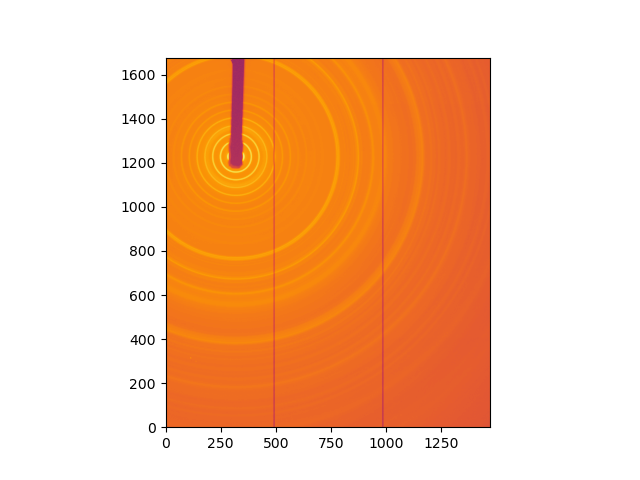

In [5]:
#iPython magic to make interactive plots work
%matplotlib widget
#Declare your path to calibration folder
calib_path ='/Users/Thomas2/Desktop/ALS_GIWAXS_June2022/AgB_Calibration/'
#Select calibration file
img = np.fromfile(calib_path + 'AgB_2022_06_29_tiled_sfloat_2m.gb', dtype=np.float32)
img = img.reshape([1679,1475])
# img = fabio.open(calib_path+'AgB_2022_06_29_tiled_hi_2m.edf').data
#pyFAI.gui command to display 2D detector image
jupyter.display(img)

"tiled_hi" calibration

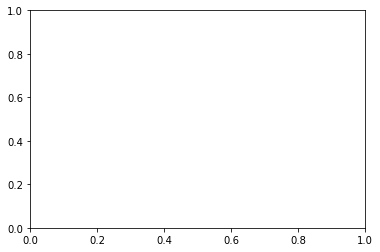

In [4]:
from pyFAI.test.utilstest import UtilsTest
from pyFAI.calibrant import CALIBRANT_FACTORY
from pyFAI.gui.jupyter.calib import Calibration
#Declare your path to calibration folder
calib_path ='/Users/Thomas2/Desktop/ALS_GIWAXS_June2022/AgB_Calibration/'

#initialize parameters of the scan
wavelength = 1.2398e-10
pilatus = pyFAI.detector_factory('Pilatus2M')
AgBh = pyFAI.calibrant.CALIBRANT_FACTORY("AgBh")
AgBh.wavelength=wavelength

#load calibration file
img = np.fromfile(calib_path + 'AgB_2022_06_29_tiled_sfloat_2m.gb', dtype=np.float32)
img = img.reshape([1679,1475])

#display calibration widget
calib = Calibration(img, calibrant=AgBh, wavelength=wavelength, detector=pilatus)
# 1. Set the ring number (0-based value), below the plot
# 2. Pick the ring by right-clicking with the mouse on the image.
# 3. Start at 1. for at least a second ring
# 4. Click refine to launch the calibration.
# Other notes: 
# "left click + d" to remove current group, 
# "right click + m" to find more points for current group
# "left click + 1" erase closest point from current group
# "left click + b" create new group with single point
# "left click + v" add single point to current group

##This calibration widget will not work for the stitched image for some reason. 
##I had to use pyFAI-calib2 command in terminal and use the old gui with a custom defined detector and skipped this step

In [63]:
#Saves calibration information
gr = calib.geoRef
#Prints info on the fit
print(gr)
print(calib.fixed)
print(gr.chi2())
#save to .poni file for use in pygix
gr.save(calib_path + 'calibration_sfloat_jupyter.poni')

Detector Pilatus 2M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.239800e-10m
SampleDetDist= 3.799595e-02m	PONI= 2.026681e-01, -2.051312e-01m	rot1=0.100000  rot2= 0.100000  rot3= 0.000000 rad
DirectBeamDist= 38.378mm	Center: x=-1214.788, y=1200.579 pix	Tilt=8.096 deg  tiltPlanRotation= 134.857 deg
['wavelength', 'rot3']
265.4756857903313


In [8]:
#Optional new fit with rotations fixed to 0
gr = calib.geoRef
gr.rot1=gr.rot2=gr.rot3=0
gr.center_array=[318, 1277]
gr.set_dist = 2.837
gr.refine3(fix=['wavelength', 'rot1', 'rot2', 'rot3', 'center_array'])
print(gr.chi2())
print(gr)
gr.save(calib_path + 'calibration_sfloat_jupyter.poni')

0.009083229969227877
Detector Pilatus 2M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.239800e-10m
SampleDetDist= 8.824057e+00m	PONI= 8.103997e-02, -4.096439e-01m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 8824.057mm	Center: x=-2381.651, y=471.163 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


In [17]:
#The next four cells are just to verify that the calibration is good (overlays expected calibrant peaks with reduced data)
#azimuthal integrator tool in pyFAI for transmission mode (use pygix for GI geometry)
ai = pyFAI.load(gr)

In [18]:
res1 = ai.integrate1d(img, 1000) #circular integration
res2 = ai.integrate2d(img, 1000) #makes caked 2d image (q vs chi)


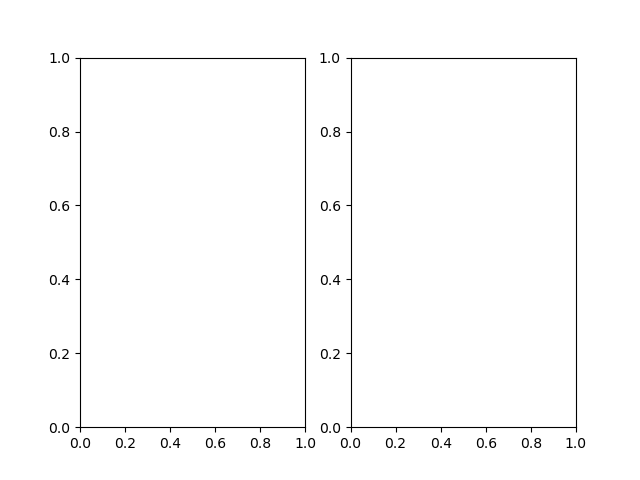

In [19]:
#initialize some interactive plots
from matplotlib.pyplot import subplots
fig, (ax1, ax2) = subplots(1, 2)



In [21]:
#populating plots with pyFAI.gui jupyter command
jupyter.plot1d(res1, ax=ax1, calibrant=AgBh)
jupyter.plot2d(res2, ax=ax2, calibrant=AgBh)
ax2.set_title('2D cake')
plt.tight_layout()

[[196. 233. 232. ... 127. 139. 113.]
 [224. 294. 294. ... 114. 128. 117.]
 [231. 282. 276. ... 114. 138. 119.]
 ...
 [ 41.  47.  43. ...  11.  18.  20.]
 [ 33.  61.  49. ...  25.  30.  21.]
 [ 41.  44.  38. ...  16.  19.  16.]]
(1679, 1475)
Detector Detector	 Spline= None	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.239842e-10m
SampleDetDist= 2.843471e-01m	PONI= 2.110720e-01, 5.454128e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 284.347mm	Center: x=317.100, y=1227.163 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


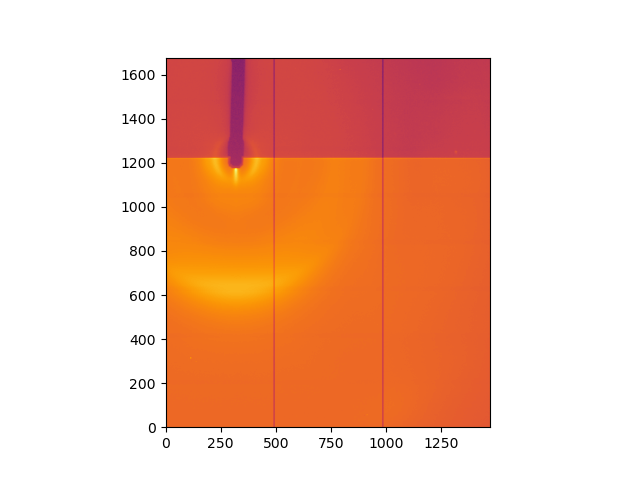

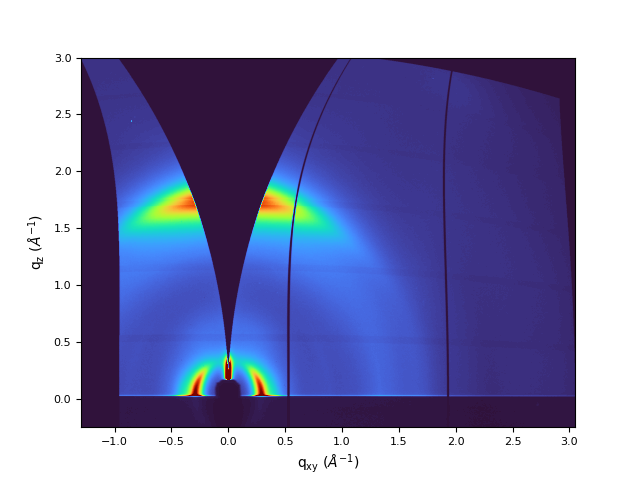

In [6]:
#Here we use our calibration to transform a single data exposure as a test
#declare sample path and open sample data
sam_path = '/Users/Thomas2/Desktop/ALS_GIWAXS_June2022/TC/'
sam = np.fromfile(sam_path + 'TC_7PM7_A0p110_30s_sfloat_2m.gb', dtype=np.float32)
sam = sam.reshape([1679,1475])
print(sam)
print(np.shape(sam))
# im = Image.fromarray(sam)
# im.save(sam_path + 'TC_7PM7_A0p110_30s_sfloat_2m.tif')
jupyter.display(sam)
#load calibration.poni file into pygix along with experimental parameters
pg = pygix.Transform()
pg.load(calib_path + 'AgB_sfloat_new.poni')
pg.sample_orientation = 3
pg.incident_angle = 0.11
print(pg)

#Convert to q-space
sam_rec, qxy, qz = pg.transform_reciprocal(sam, 
                                           method = 'bbox', #for some reason splitpix doesnt work?
                                           unit='A',)

#plotting both full qmap and zoomed in qmap
fig, ax1 = subplots(1)
img_min = np.percentile(sam_rec, 2)
img_max = np.percentile(sam_rec, 99.95)
ax1.imshow(sam_rec,
           norm=matplotlib.colors.Normalize(vmin=img_min,vmax=img_max),
           cmap='turbo',
           extent=(np.min(qxy),np.max(qxy),np.min(qz),np.max(qz)),
           origin = 'lower')
ax1.set_ylim(-0.25, 3)
ax1.set_xlabel('$\mathregular{q_{xy}}$ ($\AA^{-1}$)')
ax1.set_ylabel('$\mathregular{q_z}$ ($\AA^{-1}$)')
ax1.tick_params(axis='both', which='major', labelsize=8)

Detector Detector	 Spline= None	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.239842e-10m
SampleDetDist= 2.843471e-01m	PONI= 2.110720e-01, 5.454128e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 284.347mm	Center: x=317.100, y=1227.163 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


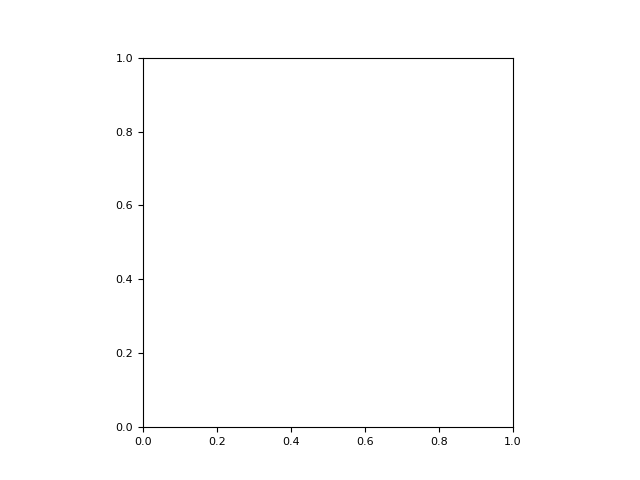

In [6]:
#This cell recursively reduces data and saves to specificed folders

import glob
import re
qmap_path = '/Users/Thomas2/Desktop/ALS_GIWAXS_June2022/Output_qmap_0p11/'
linecut_path = '/Users/Thomas2/Desktop/ALS_GIWAXS_June2022/Output_linecuts_0p11/'
pg = pygix.Transform()
pg.load(calib_path + 'AgB_sfloat_new.poni')
pg.sample_orientation = 3
pg.incident_angle = 0.11
print(pg)

fig, ax1 = subplots(1)
os.chdir('/Users/Thomas2/Desktop/ALS_GIWAXS_June2022/TC')
for name in glob.glob('*0p110_30s_sfloat_2m.gb'):
    sam = np.fromfile(name, dtype=np.float32)
    sam = sam.reshape([1679,1475])
    name_short = re.search('TC_(.*)_30s_sfloat_2m.gb', name)
    name_short = name_short.group(1)
    
    #Convert to q-space
    sam_rec, qxy, qz = pg.transform_reciprocal(sam, 
                                               method = 'bbox', #for some reason splitpix doesnt work?
                                               unit='A',)
        
    #plotting both full qmap and zoomed in qmap
    img_min = np.percentile(sam_rec, 2)
    img_max = np.percentile(sam_rec, 99.95)
    ax1.imshow(sam_rec,
               norm=matplotlib.colors.Normalize(vmin=img_min,vmax=img_max),
               cmap='turbo',
               extent=(np.min(qxy),np.max(qxy),np.min(qz),np.max(qz)),
               origin = 'lower')
    ax1.set_ylim(-0.25, 3)
    ax1.set_xlabel('$\mathregular{q_{xy}}$ ($\AA^{-1}$)')
    ax1.set_ylabel('$\mathregular{q_z}$ ($\AA^{-1}$)')
    ax1.tick_params(axis='both', which='major', labelsize=8)
    plt.savefig(qmap_path + name_short + '_qmap.png', dpi=300)
    plt.cla()
    
    
    #save the tif image, qxy, and qz arrays
    np.savetxt(qmap_path + name_short + '_qxy.txt', qxy)
    np.savetxt(qmap_path + name_short + '_qz.txt', qz)
    fabio.tifimage.TifImage(np.nan_to_num(sam_rec).astype('int')).write(qmap_path + name_short + '_qmap.tif')
    
    #generate linecuts
    i_5, q_5 = pg.profile_sector(sam, npt=1000, chi_pos=5, chi_width=10,
                                 radial_range=(0, 2.5), unit='q_A^-1', 
                                 correctSolidAngle=False, method="bbox")
    i_15, q_15 = pg.profile_sector(sam, npt=1000, chi_pos=15, chi_width=10,
                                 radial_range=(0, 2.5), unit='q_A^-1', 
                                 correctSolidAngle=False, method="bbox")
    i_25, q_25 = pg.profile_sector(sam, npt=1000, chi_pos=25, chi_width=10,
                                 radial_range=(0, 2.5), unit='q_A^-1', 
                                 correctSolidAngle=False, method="bbox")
    i_35, q_35 = pg.profile_sector(sam, npt=1000, chi_pos=35, chi_width=10,
                                 radial_range=(0, 2.5), unit='q_A^-1', 
                                 correctSolidAngle=False, method="bbox")
    i_45, q_45 = pg.profile_sector(sam, npt=1000, chi_pos=45, chi_width=10,
                                 radial_range=(0, 2.5), unit='q_A^-1', 
                                 correctSolidAngle=False, method="bbox")
    i_55, q_55 = pg.profile_sector(sam, npt=1000, chi_pos=55, chi_width=10,
                                 radial_range=(0, 2.5), unit='q_A^-1', 
                                 correctSolidAngle=False, method="bbox")
    i_65, q_65 = pg.profile_sector(sam, npt=1000, chi_pos=65, chi_width=10,
                                 radial_range=(0, 2.5), unit='q_A^-1', 
                                 correctSolidAngle=False, method="bbox")
    i_75, q_75 = pg.profile_sector(sam, npt=1000, chi_pos=75, chi_width=10,
                                 radial_range=(0, 2.5), unit='q_A^-1', 
                                 correctSolidAngle=False, method="bbox")
    i_85, q_85 = pg.profile_sector(sam, npt=1000, chi_pos=85, chi_width=10,
                                 radial_range=(0, 2.5), unit='q_A^-1', 
                                 correctSolidAngle=False, method="bbox")
    
    np.savetxt(linecut_path + name_short + '_5deg_linecut.txt', np.vstack((q_5, i_5)).T)
    np.savetxt(linecut_path + name_short + '_15deg_linecut.txt', np.vstack((q_15, i_15)).T)
    np.savetxt(linecut_path + name_short + '_25deg_linecut.txt', np.vstack((q_25, i_25)).T)
    np.savetxt(linecut_path + name_short + '_35deg_linecut.txt', np.vstack((q_35, i_35)).T)
    np.savetxt(linecut_path + name_short + '_45deg_linecut.txt', np.vstack((q_45, i_45)).T)
    np.savetxt(linecut_path + name_short + '_55deg_linecut.txt', np.vstack((q_55, i_55)).T)
    np.savetxt(linecut_path + name_short + '_65deg_linecut.txt', np.vstack((q_65, i_65)).T)
    np.savetxt(linecut_path + name_short + '_75deg_linecut.txt', np.vstack((q_75, i_75)).T)
    np.savetxt(linecut_path + name_short + '_85deg_linecut.txt', np.vstack((q_85, i_85)).T)

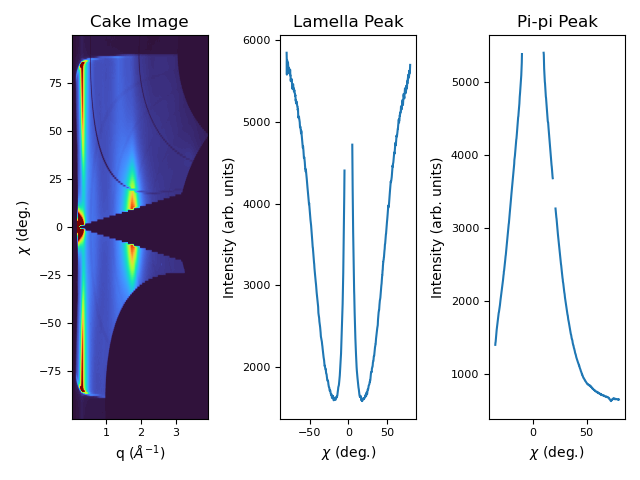

In [56]:
#Test of cake image and pole figs
sam_cake, qr, chi = pg.transform_polar(sam, 
                                       method = 'bbox',
                                       unit='A')
img_min = np.percentile(sam_rec, 2)
img_max = np.percentile(sam_rec, 99.95)
fig, (ax1, ax2, ax3) = subplots(1,3)
ax1.imshow(sam_cake,
   norm=matplotlib.colors.Normalize(vmin=img_min,vmax=img_max),
   cmap='turbo',
   extent=(np.min(qr),np.max(qr),np.min(chi),np.max(chi)),
   origin = 'lower',
   aspect='auto')

ax1.set_xlabel('$\mathregular{q}$ ($\AA^{-1}$)')
ax1.set_ylabel('$\chi$ (deg.)')
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.set_title('Cake Image')

i_lamella, chi_lamella = pg.profile_chi(sam, npt=1000, radial_pos = 0.3, radial_width = 0.05,
                                        chi_range=(-80,80), unit='q_A^-1', 
                                        correctSolidAngle=True, method="bbox")

i_lamella=np.array(i_lamella)
chi_lamella=np.array(chi_lamella)
for i in range(len(chi_lamella)):
    if abs(chi_lamella[i])<5:
        i_lamella[i]=np.nan
        
ax2.plot(chi_lamella, i_lamella)
ax2.set_xlabel('$\chi$ (deg.)')
ax2.set_ylabel('Intensity (arb. units)')
ax2.tick_params(axis='both', which='major', labelsize=8)
ax2.set_title('Lamella Peak')

i_pi, chi_pi = pg.profile_chi(sam, npt=1000, radial_pos = 1.7, radial_width = 0.2,
                                        chi_range=(-80,80), unit='q_A^-1', 
                                        correctSolidAngle=True, method="bbox")

i_lamella=np.array(i_pi)
chi_lamella=np.array(chi_pi)
for i in range(len(chi_pi)):
    if chi_pi[i]<-35:
        i_pi[i]=np.nan
    if abs(chi_pi[i])<10:
        i_pi[i]=np.nan
    if chi_pi[i]<21 and chi_pi[i]>18.5:
        i_pi[i]=np.nan
        
ax3.plot(chi_pi, i_pi)
ax3.set_xlabel('$\chi$ (deg.)')
ax3.set_ylabel('Intensity (arb. units)')
ax3.tick_params(axis='both', which='major', labelsize=8)
ax3.set_title('Pi-pi Peak')

plt.tight_layout()